In [1]:
import numpy as np
from tqdm import tqdm
import tensorflow as tf
from datetime import datetime
import pipeline
import pickle
from config import Config

%load_ext tensorboard

In [2]:
print(tf.test.is_gpu_available(),tf.test.is_built_with_cuda())

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True True


In [3]:
# Parameters Based on Paper
epsilon = 1e-7
m_plus = 0.9
m_minus = 0.1
lambda_ = 0.5
alpha = 0.0005
epochs = 50
no_of_secondary_capsules = 10
hidden_units = 10

optimizer = tf.keras.optimizers.Adam()

In [4]:
params = {
    "no_of_conv_kernels": 256,
    "no_of_primary_capsules": 32,
    "no_of_secondary_capsules": 10,
    "primary_capsule_vector": 8,
    "secondary_capsule_vector": 16,
    "r":3,
}
pruning_time = 0

In [5]:
checkpoint_path = 'D:\year-end-project/models/gui/logs/encoder_kmnist_similarity_logs/model/capsule'

stamp = datetime.now().strftime("%Y%m%d-%H%M%S")

logdir = 'D:\year-end-project/models/gui/logs/encoder_kmnist_similarity_logs/func/%s' % stamp
writer = tf.summary.create_file_writer(logdir)

scalar_logdir = 'D:\year-end-project/models/gui/logs/encoder_kmnist_similarity_logs/scalars/%s' % stamp
file_writer = tf.summary.create_file_writer(scalar_logdir + "/metrics")

In [6]:
# kmnist = pipeline.CreateDataset("kmnist",False)
# kmnist.run()
# (X_train, y_train), (X_test , y_test) = kmnist.get_train_test() 
with open('kmnist/kmnist.pkl', 'rb') as f:
    data = pickle.load(f)
X_train = data["X_train"]
y_train = data["y_train"]
X_test = data["X_test"]
y_test = data["y_test"]

In [7]:
X_train = X_train / 255.0
X_train = tf.cast(X_train, dtype=tf.float32)
# X_train = tf.expand_dims(X_train, axis=-1)

X_test = X_test / 255.0
X_test = tf.cast(X_test, dtype=tf.float32)
# X_test = tf.expand_dims(X_test, axis=-1)

In [8]:
testing_dataset_size = X_test.shape[0]
training_dataset_size = X_train.shape[0]

In [9]:
dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
dataset = dataset.shuffle(buffer_size=len(dataset), reshuffle_each_iteration=True)
dataset = dataset.batch(batch_size=64)

In [10]:
testing = tf.data.Dataset.from_tensor_slices((X_test, y_test))
testing = testing.batch(batch_size=64)

In [11]:
class CapsuleNetwork(tf.keras.Model):
    def __init__(self, no_of_conv_kernels, no_of_primary_capsules, primary_capsule_vector, no_of_secondary_capsules, secondary_capsule_vector, r):
        super(CapsuleNetwork, self).__init__()
        self.no_of_conv_kernels = no_of_conv_kernels
        self.no_of_primary_capsules = no_of_primary_capsules
        self.primary_capsule_vector = primary_capsule_vector
        self.no_of_secondary_capsules = no_of_secondary_capsules
        self.secondary_capsule_vector = secondary_capsule_vector
        self.r = r
        
        
        with tf.name_scope("Variables") as scope:
            self.convolution = tf.keras.layers.Conv2D(self.no_of_conv_kernels, [9,9], strides=[1,1], name='ConvolutionLayer', activation='relu')
            self.primary_capsule = tf.keras.layers.Conv2D(self.no_of_primary_capsules * self.primary_capsule_vector, [9,9], strides=[2,2], name="PrimaryCapsule")
            self.w = tf.Variable(tf.random_normal_initializer()(shape=[1, 1152, self.no_of_secondary_capsules, self.secondary_capsule_vector, self.primary_capsule_vector]), dtype=tf.float32, name="PoseEstimation", trainable=True)
            self.dense_1 = tf.keras.layers.Dense(units = 512, activation='relu')
            self.dense_2 = tf.keras.layers.Dense(units = 1024, activation='relu')
            self.dense_3 = tf.keras.layers.Dense(units = 784, activation='sigmoid', dtype='float32')
            self.query_layer = tf.keras.layers.Dense(16)
            self.key_layer = tf.keras.layers.Dense(16)
            self.value_layer = tf.keras.layers.Dense(16)
        
    def build(self, input_shape):
        pass
        
    def squash(self, s):
        with tf.name_scope("SquashFunction") as scope:
            s_norm = tf.norm(s, axis=-1, keepdims=True)
            return tf.square(s_norm)/(1 + tf.square(s_norm)) * s/(s_norm + epsilon)
    
    def self_attention(self,input_tensor, hidden_size = 16, activation=tf.nn.relu):
        query = self.query_layer(input_tensor)
        key = self.key_layer(input_tensor)
        value = self.value_layer(input_tensor)

        attention_scores = tf.matmul(query, key, transpose_b=True)
        attention_scores = tf.divide(attention_scores, tf.sqrt(tf.cast(hidden_size, tf.float32)))

        attention_weights = tf.nn.softmax(attention_scores)

        attended_values = tf.matmul(attention_weights, value)

        return attended_values
    
    @tf.function
    def call(self, inputs):
        input_x, y = inputs
        # input_x.shape: (None, 28, 28, 1)
        # y.shape: (None, 10)
        
        x = self.convolution(input_x) # x.shape: (None, 20, 20, 256)
        x = self.primary_capsule(x) # x.shape: (None, 6, 6, 256)
        
        with tf.name_scope("CapsuleFormation") as scope:
            u = tf.reshape(x, (-1, self.no_of_primary_capsules * x.shape[1] * x.shape[2], 8)) # u.shape: (None, 1152, 8)
            u = tf.expand_dims(u, axis=-2) # u.shape: (None, 1152, 1, 8)
            u = tf.expand_dims(u, axis=-1) # u.shape: (None, 1152, 1, 8, 1)
            u_hat = tf.matmul(self.w, u) # u_hat.shape: (None, 1152, 10, 16, 1)
            u_hat = tf.squeeze(u_hat, [4]) # u_hat.shape: (None, 1152, 10, 16)

        
        with tf.name_scope("DynamicRouting") as scope:
            b = tf.zeros((input_x.shape[0], 1152, self.no_of_secondary_capsules, 1)) # b.shape: (None, 1152, 10, 1)
            for i in range(self.r): # self.r = 3
                c = tf.nn.softmax(b, axis=-2) # c.shape: (None, 1152, 10, 1)
                s = tf.reduce_sum(tf.multiply(c, u_hat), axis=1, keepdims=True) # s.shape: (None, 1, 10, 16)
                v = self.squash(s) # v.shape: (None, 1, 10, 16)
                agreement = tf.squeeze(tf.matmul(tf.expand_dims(u_hat, axis=-1), tf.expand_dims(v, axis=-1), transpose_a=True), [4]) # agreement.shape: (None, 1152, 10, 1)
                b += agreement
                
        with tf.name_scope("Masking") as scope:
            y = tf.expand_dims(y, axis=-1) # y.shape: (None, 10, 1)
            y = tf.expand_dims(y, axis=1) # y.shape: (None, 1, 10, 1)
            mask = tf.cast(y, dtype=tf.float32) # mask.shape: (None, 1, 10, 1)
            v_masked = tf.multiply(mask, v) # v_masked.shape: (None, 1, 10, 16)
            
        with tf.name_scope("Reconstruction") as scope:
            v_ = tf.reshape(v_masked, [-1, self.no_of_secondary_capsules * self.secondary_capsule_vector]) # v_.shape: (None, 160)
            reconstructed_image = self.self_attention(v_)
            reconstructed_image = self.dense_1(reconstructed_image) # reconstructed_image.shape: (None, 512)
            reconstructed_image = self.dense_2(reconstructed_image) # reconstructed_image.shape: (None, 1024)
            reconstructed_image = self.dense_3(reconstructed_image) # reconstructed_image.shape: (None, 784)
        
        return v, reconstructed_image

    @tf.function
    def predict_capsule_output(self, inputs):
        x = self.convolution(inputs) # x.shape: (None, 20, 20, 256)
        x = self.primary_capsule(x) # x.shape: (None, 6, 6, 256)
        
        with tf.name_scope("CapsuleFormation") as scope:
            u = tf.reshape(x, (-1, self.no_of_primary_capsules * x.shape[1] * x.shape[2], 8)) # u.shape: (None, 1152, 8)
            u = tf.expand_dims(u, axis=-2) # u.shape: (None, 1152, 1, 8)
            u = tf.expand_dims(u, axis=-1) # u.shape: (None, 1152, 1, 8, 1)
            u_hat = tf.matmul(self.w, u) # u_hat.shape: (None, 1152, 10, 16, 1)
            u_hat = tf.squeeze(u_hat, [4]) # u_hat.shape: (None, 1152, 10, 16)

        
        with tf.name_scope("DynamicRouting") as scope:
            b = tf.zeros((inputs.shape[0], 1152, self.no_of_secondary_capsules, 1)) # b.shape: (None, 1152, 10, 1)
            for i in range(self.r): # self.r = 3
                c = tf.nn.softmax(b, axis=-2) # c.shape: (None, 1152, 10, 1)
                s = tf.reduce_sum(tf.multiply(c, u_hat), axis=1, keepdims=True) # s.shape: (None, 1, 10, 16)
                v = self.squash(s) # v.shape: (None, 1, 10, 16)
                agreement = tf.squeeze(tf.matmul(tf.expand_dims(u_hat, axis=-1), tf.expand_dims(v, axis=-1), transpose_a=True), [4]) # agreement.shape: (None, 1152, 10, 1)
                b += agreement
        return v

    @tf.function
    def regenerate_image(self, inputs):
        with tf.name_scope("Reconstruction") as scope:
            v_ = tf.reshape(inputs, [-1, self.no_of_secondary_capsules * self.secondary_capsule_vector]) # v_.shape: (None, 160)
            reconstructed_image = self.self_attention(v_)
            reconstructed_image = self.dense_1(reconstructed_image) # reconstructed_image.shape: (None, 512)
            reconstructed_image = self.dense_2(reconstructed_image) # reconstructed_image.shape: (None, 1024)
            reconstructed_image = self.dense_3(reconstructed_image) # reconstructed_image.shape: (None, 784)
        return reconstructed_image

In [12]:
tf.summary.trace_on(graph=True, profiler=True)

Instructions for updating:
use `tf.profiler.experimental.start` instead.


In [13]:
model = CapsuleNetwork(**params)

In [14]:
def safe_norm(v, axis=-1, epsilon=1e-7):
    v_ = tf.reduce_sum(tf.square(v), axis = axis, keepdims=True)
    return tf.sqrt(v_ + epsilon)

In [15]:
def loss_function(v, reconstructed_image, y, y_image):
    prediction = safe_norm(v)
    prediction = tf.reshape(prediction, [-1, no_of_secondary_capsules])
    
    left_margin = tf.square(tf.maximum(0.0, m_plus - prediction))
    right_margin = tf.square(tf.maximum(0.0, prediction - m_minus))
    
    l = tf.add(y * left_margin, lambda_ * (1.0 - y) * right_margin)
    
    margin_loss = tf.reduce_mean(tf.reduce_sum(l, axis=-1))
    
    y_image_flat = tf.reshape(y_image, [-1, 784])
    reconstruction_loss = tf.reduce_mean(tf.square(y_image_flat - reconstructed_image))
    
    loss = tf.add(margin_loss, alpha * reconstruction_loss)
    
    return loss

In [16]:
# def prune_model_similarity(model, similarity_threshold=0.9):
#     p_start_time = datetime.now()
#     for layer in model.layers:
#         if isinstance(layer, tf.keras.layers.Conv2D) or isinstance(layer, tf.keras.layers.Dense):
#             weights = layer.get_weights()
#             if len(weights) > 0:  # Check if layer has trainable weights
#                 w = weights[0]  # Get the weight matrix
#                 w_norm = np.linalg.norm(w, axis=0)  # Compute L2 norm of weights
#                 w_normalized = w / w_norm  # Normalize weights
#                 similarity_matrix = np.abs(np.dot(w_normalized.T, w_normalized))  # Compute cosine similarity matrix
#                 mask = (similarity_matrix > similarity_threshold)  # Create mask for keeping important weights
#                 w_pruned = w * mask  # Apply mask to weights
#                 weights[0] = w_pruned  # Update layer weights
#                 layer.set_weights(weights)  # Set pruned weights back to layer\
#     p_end_time = datetime.now()
#     pruning_time += p_end_time - p_start_time


In [17]:
def train(x,y):
    y_one_hot = tf.one_hot(y, depth=10)
    with tf.GradientTape() as tape:
        v, reconstructed_image = model([x, y_one_hot]) 
        loss = loss_function(v, reconstructed_image, y_one_hot, x)
    grad = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grad, model.trainable_variables))
    return loss

In [18]:
_ = train(X_train[:32],y_train[:32])
with writer.as_default():
    tf.summary.trace_export(name="my_func_trace", step=0, profiler_outdir=logdir)

Instructions for updating:
use `tf.profiler.experimental.stop` instead.
Instructions for updating:
`tf.python.eager.profiler` has deprecated, use `tf.profiler` instead.
Instructions for updating:
`tf.python.eager.profiler` has deprecated, use `tf.profiler` instead.


In [19]:
tf.summary.trace_off()

In [20]:
model.summary()

Model: "capsule_network"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ConvolutionLayer (Conv2D)   multiple                  20992     
                                                                 
 PrimaryCapsule (Conv2D)     multiple                  5308672   
                                                                 
 dense (Dense)               multiple                  8704      
                                                                 
 dense_1 (Dense)             multiple                  525312    
                                                                 
 dense_2 (Dense)             multiple                  803600    
                                                                 
 dense_3 (Dense)             multiple                  2576      
                                                                 
 dense_4 (Dense)             multiple              

In [21]:
def predict(model, x):
    pred = safe_norm(model.predict_capsule_output(x))
    pred = tf.squeeze(pred, [1])
    return np.argmax(pred, axis=1)[:,0]

In [22]:
checkpoint = tf.train.Checkpoint(model=model)

In [24]:
def prune_model_similarity(model, threshold):
    for layer in model.layers:
        if layer.trainable:
            for variable in layer.trainable_variables:
                weights = variable.numpy()
                similarity_matrices = []
                for i in range(256):
                    feature_map = tf.reshape(weights[:, :, :, i], shape=(9, 9))
                    similarity_matrix = tf.keras.losses.cosine_similarity(feature_map[:, None], feature_map[None, :], axis=-1)
                    similarity_matrices.append(similarity_matrix)
                similarity_matrices = tf.stack(similarity_matrices, axis=-1)
                binary_masks = tf.cast(tf.math.greater_equal(similarity_matrices, threshold), tf.float32)
                pruned_weights = tf.multiply(weights, tf.expand_dims(tf.expand_dims(binary_masks, axis=0), axis=-1))
                layer.set_weights(pruned_weights)

In [25]:
start_time = datetime.now()
losses = []
accuracy = []
for i in range(1, epochs+1, 1):

    loss = 0
    with tqdm(total=len(dataset)) as pbar:
        
        description = "Epoch " + str(i) + "/" + str(epochs)
        pbar.set_description_str(description)

        for X_batch, y_batch in dataset:

            loss += train(X_batch,y_batch)
            pbar.update(1)
            
        if i % 2 != 0:
            prune_model_similarity(model,0.2)
        loss /= len(dataset)
        losses.append(loss.numpy())
        
        training_sum = 0

        print_statement = "Loss :" + str(loss.numpy()) + " Evaluating Accuracy ..."
        pbar.set_postfix_str(print_statement)

        for X_batch, y_batch in dataset:
            training_sum += sum(predict(model, X_batch)==y_batch.numpy())
        accuracy.append(training_sum/training_dataset_size)

        with file_writer.as_default():
            tf.summary.scalar('Loss', data=loss.numpy(), step=i)
            tf.summary.scalar('Accuracy', data=accuracy[-1], step=i)
        
        print_statement = "Loss :" + str(loss.numpy()) + " Accuracy :" + str(accuracy[-1])
        if i % 5 == 0:
            print_statement += ' Checkpoint Saved'
            checkpoint.save(checkpoint_path)
        
        pbar.set_postfix_str(print_statement)

end_time = datetime.now()

Epoch 50/50: 100%|██████████| 930/930 [09:50<00:00,  1.58it/s, Loss :0.0021159349 Accuracy :0.9997142857142857 Checkpoint Saved]


In [26]:
elapsed_time = end_time - start_time
hours, remainder = divmod(elapsed_time.total_seconds(), 3600)
minutes, seconds = divmod(remainder, 60)

print("Elapsed time: {:.0f} hours, {:.0f} minutes, {:.2f} seconds".format(hours, minutes, seconds))

Elapsed time: 8 hours, 11 minutes, 57.25 seconds


In [30]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

test_sum = 0
test_predictions = []
test_labels = []
for X_batch, y_batch in testing:
    test_predictions = predict(model, X_batch)==y_batch.numpy()
    test_labels.extend(y_batch.numpy())
    test_sum += sum(predict(model, X_batch)==y_batch.numpy())

print(test_sum/testing_dataset_size)


0.9602857142857143


In [31]:
y_test[:90]

array([5, 4, 8, 7, 4, 7, 5, 7, 9, 0, 2, 2, 5, 8, 7, 2, 3, 8, 1, 1, 2, 4,
       6, 3, 6, 0, 7, 5, 2, 6, 8, 4, 6, 7, 5, 2, 0, 4, 8, 9, 0, 3, 8, 1,
       3, 9, 8, 2, 5, 2, 5, 2, 1, 1, 9, 4, 0, 5, 1, 9, 0, 7, 4, 0, 2, 1,
       8, 8, 0, 9, 4, 2, 6, 4, 0, 0, 0, 6, 1, 9, 7, 4, 3, 1, 2, 1, 3, 1,
       1, 9], dtype=uint8)

In [32]:
import random
index_ = 3
index = index_

In [33]:
print(predict(model, tf.expand_dims(X_test[index_], axis=0)), y_test[index_])

[7] 7


In [34]:
features = model.predict_capsule_output(tf.expand_dims(X_test[index_], axis=0))

In [35]:
features.shape

TensorShape([1, 1, 10, 16])

In [36]:
from datetime import datetime
from matplotlib import pyplot as plt

(1, 784) (1, 1, 10, 16)


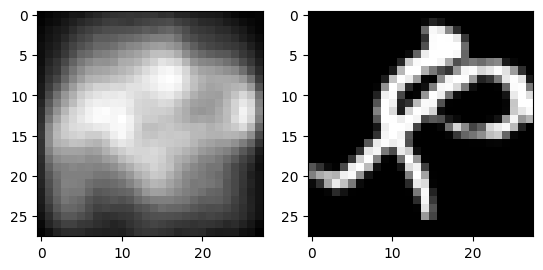

In [37]:
temp_features = features.numpy()
temp_ = temp_features.copy()
temp_features[:,:,:,:] = 0
temp_features[:,:,index,:] = temp_[:,:,index,:]

recon = model.regenerate_image(temp_features)
print(recon.shape,temp_features.shape)
recon = tf.reshape(recon, (28,28))

plt.subplot(1,2,1)
plt.imshow(recon, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(X_test[index_,:,:,0], cmap='gray')

In [38]:
col = np.zeros((28,308))
for i in range(16): 
    feature_ = temp_features.copy()
    feature_[:,:,index, i] += -0.25
    row = np.zeros((28,28))
    for j in range(10):
        feature_[:,:,index, i] += 0.05
        row = np.hstack([row, tf.reshape(model.regenerate_image(tf.convert_to_tensor(feature_)), (28,28)).numpy()])
    col = np.vstack([col, row])

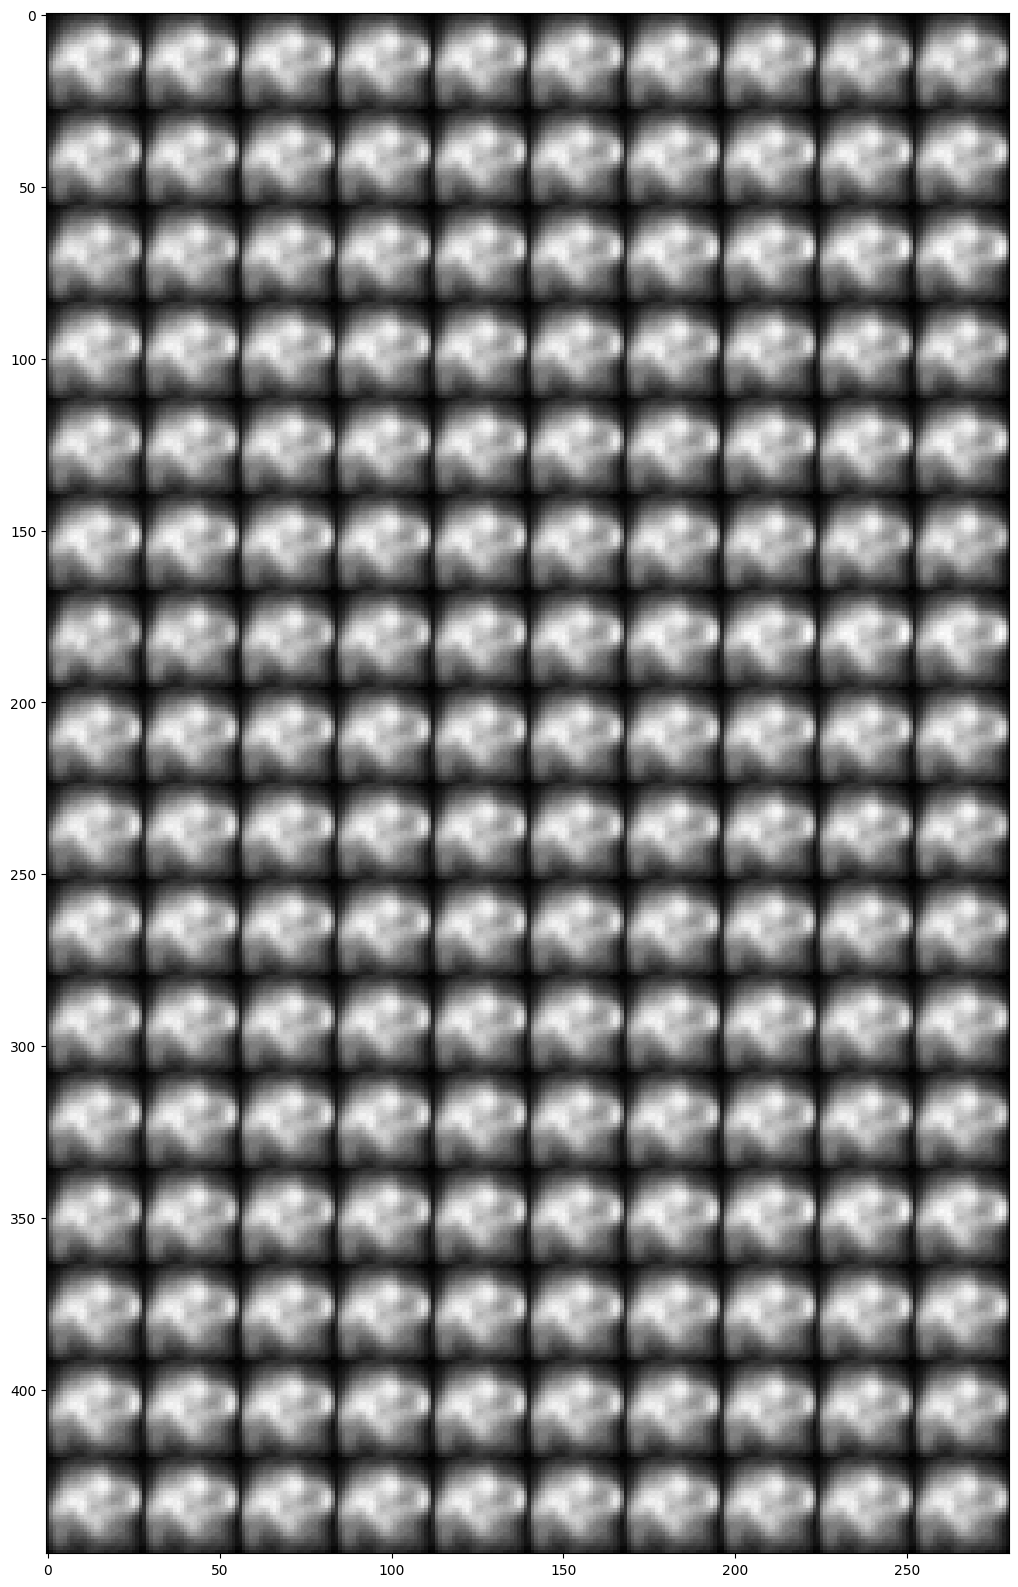

In [39]:
plt.figure(figsize=(30,20))
plt.imshow(col[28:, 28:], cmap='gray')